# Alzheimer's Disease Prediction

#### Prediction of Alzheimer disease based on MRI Preprocessed Dataset. The dataset can be found via [this link](https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset). The method used is image classification via transfer learning 


In [1]:
# import necessary modules
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

In [ ]:
# set variable for file_path and data_dir
file_path ='/content/drive/MyDrive/Alzheimer_s Dataset/'
data_dir = pathlib.Path(file_path)
# Split train and validation data
SEED = 1234
BATCH_SIZE = 10
IMG_SIZE = (160,160)

In [ ]:


train_data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                         validation_split = 0.2,  
                                                         subset = 'training',
                                                         seed = SEED,
                                                         image_size = IMG_SIZE,
                                                         batch_size = BATCH_SIZE,
                                                         shuffle = True
                                                         )

val_data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split = 0.2,
                                                       subset = 'validation',
                                                       seed = SEED,
                                                       image_size = IMG_SIZE,
                                                       batch_size = BATCH_SIZE,
                                                       shuffle = True
                                                       )

Found 4840 files belonging to 2 classes.
Using 3872 files for training.
Found 4840 files belonging to 2 classes.
Using 968 files for validation.


In [ ]:
print(f"total train data per batch: {len(train_data)}")
print(f"total validation data per batch: {len(val_data)}")

total train data per batch: 388
total validation data per batch: 97


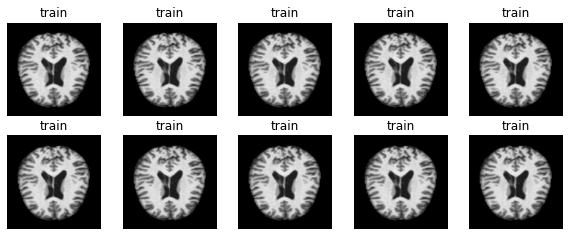

In [ ]:
# set variable for class_names
class_names = train_data.class_names

# plot the train_data image
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
  for i in range(10):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[1].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
#  perform split of validation data into test data
val_batches = tf.data.experimental.cardinality(val_data)
test_data = val_data.take(val_batches//2)
val_data = val_data.skip(val_batches//2)

In [ ]:
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_data)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_data)}")

Number of validation batches: 49
Number of test batches: 48


In [ ]:
print(f"total train data: {len(train_data)}")
print(f"total validation data: {len(val_data)}")
print(f"total test data: {len(test_data)}")

total train data: 388
total validation data: 49
total test data: 48


In [ ]:
# create prefetch dataset for better performance
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size = AUTOTUNE)
val_data = val_data.prefetch(buffer_size = AUTOTUNE)


In [ ]:
# preprocess image input to rescale the image to fit into the pre-trained model
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.Xception(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet'
                                         )

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 79, 79, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [ ]:
base_model.trainable=True 

In [ ]:
# re-construct the model
inputs = tf.keras.Input(shape = (160,160,3))
x = preprocess_input(inputs)
x = base_model(x, training = True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs =tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# predicting images
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix

subfolders = [ f.path for f in os.scandir(file_path) if f.is_dir() ]
def get_index_of_biggest(arr):
  max_value = max(list(arr))
  max_index = list(arr).index(max_value)
  return max_index
def simple_predict():
  classes = ["MildDemented","ModerateDemented","NonDemented","VeryMildDemented"]
  true_vals = []
  pred_vals = []
  for dir in subfolders:
    _class_ = dir.split("/")
    _class_ = _class_[len(_class_)-1]
    i,_file_ = 0,list(os.scandir(dir))
    while i < len(_file_):
      file_to_use = str(_file_[i]).replace("<DirEntry '",'').replace("'>","")
      img = image.load_img(dir+"/"+str(file_to_use), target_size=(160, 160))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      images = np.vstack([x])
      prediction = model.predict(images, batch_size=10)
      true_vals.append(_class_)
      pred_vals.append(classes[get_index_of_biggest(prediction[0])])
      if i < 10:
        i = i+1
      else:
        break
  return true_vals,pred_vals
y_t,y_p = simple_predict()
print(confusion_matrix(y_t,y_p))

IsADirectoryError: ignored

In [ ]:
# compile the model
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy']
              )

In [ ]:
model.save('/content/Xception.h5')

In [ ]:
# check the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 160, 160, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0     

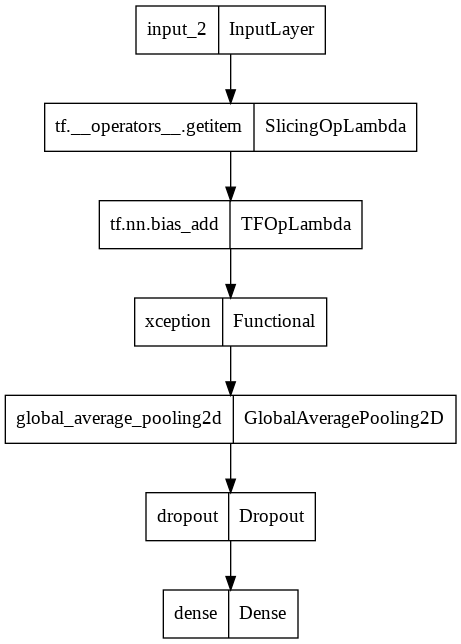

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
loss0, accuracy0 = model.evaluate(val_data)

print("---------------------------------------------Before Training---------------------------------------------")
print("loss", loss0)
print("accuracy", accuracy0)

49/49 [==============================] - 138s 1s/step - loss: 1.2051 - accuracy: 0.5041
---------------------------------------------Before Training---------------------------------------------
loss 1.2051427364349365
accuracy 0.5040983557701111


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from gc import callbacks
import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
es_callback = callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 2)

In [ ]:
# start train the model
initial_epochs = 50 
history = model.fit(train_data,
                    epochs = initial_epochs,
                    validation_data = val_data,
                    callbacks = [tensorboard_callback, es_callback])

Epoch 1/50
330/388 [========================>.....] - ETA: 1:15 - loss: 0.0532 - accuracy: 0.0055

In [ ]:
# View training accuracy and loss graph via tensorboard
%tensorboard --logdir logs

In [ ]:
# let's take a look at the model layers
print("Number of layers in the base model: ", len(base_model.layers))

In [ ]:
# So, we are going to fine-tune 10 layers ahead
fine_tune_at = 10

# Freeze all the layer before "fine_tune_at" layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
# lets check the model again
model.summary()

In [ ]:
# compile the model
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy']
              )

In [ ]:
# Now, we resume the model trianing from the last epochs
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

# train the model again
histroy_fine_tune = model.fit(train_data,
                              epochs = total_epochs,
                              initial_epoch = history.epoch[-1],
                              validation_data = val_data,
                              callbacks = [tensorboard_callback, es_callback])

In [ ]:
# View training accuracy and loss graph via tensorboard
%tensorboard --logdir logs

In [ ]:
# Evaluate the model
print("-----------------------------------After Fine-tuning model..........................................")
model.evaluate(test_data)

In [ ]:
# Use test data to make prediction
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
class_predictions = np.argmax(predictions, axis=1)

In [ ]:
class_predictions

In [ ]:
# plot the prediction vs actual label
plt.figure(figsize = (20,20))
for i in range(10):
  axs = plt.subplot(5,5,i+1)
  plt.imshow(image_batch[i].astype("uint8"))
  current_prediction = class_names[class_predictions[i]]
  current_label = class_names[label_batch[i]]
  plt.title(f"Prediction: {current_prediction} \n Actual: {current_label}")
  plt.axis('off')

# CNN-**LSTM**

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape = (160,160,3)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
                                        

model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(1
                            , (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Reshape(target_shape=(38, 38)))

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu',
                                                             return_sequences=False)))

#tf.keras.layers.Bidirectional(

model.add(tf.keras.layers.Dense(2032, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.summary()


In [ ]:
base_learning_rate = 0.0002
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy']
              )

In [ ]:
model.save('/content/CNNRNN.h5')

In [ ]:
# start train the model
initial_epochs = 50 
history = model.fit(train_data,
                    epochs = initial_epochs,
                    validation_data = val_data)


In [ ]:
# Evaluate the model
print("-----------------------------------After Fine-tuning model..........................................")
model.evaluate(test_data)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
)

## **RNN(GRU)**

In [ ]:
train = datagen.flow_from_directory(
    file_path,
    target_size=(160,160),
    color_mode='grayscale',
    subset="training" 
)
valid = datagen.flow_from_directory(
    file_path,
    target_size=(160,160),
    color_mode='grayscale',
    subset="validation"
)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape = (160,160,1)))
model.add(tf.keras.layers.Reshape(target_shape=(160,160)))

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, activation='relu',
                                                             return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='relu',
                                                             return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, activation='relu',
                                                             return_sequences=False)))

#tf.keras.layers.Bidirectional(

model.add(tf.keras.layers.Dense(2032, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.summary()


In [ ]:
base_learning_rate = 0.0002
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy']
              )

In [ ]:
model.save('/content/RNN.h5')

In [ ]:
# start train the model
initial_epochs = 50 
history = model.fit(train,
                    epochs = initial_epochs,
                    validation_data = valid)


In [ ]:
# Evaluate the model
print("-----------------------------------After Fine-tuning model..........................................")
model.evaluate(test_data)